# Predicting Chronic Kidney Disease based on health records
Given 24 health related attributes taken in 2-month period of 400 patients, using the information of the 158 patients with complete records to predict the outcome (i.e. whether one has chronic kidney disease) of the remaining 242 patients (with missing values in their records).



## Load Modules and helper functions

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

def auc_scorer(clf, X, y, model): # Helper function to plot the ROC curve
    if model=='RF':
        fpr, tpr, _ = roc_curve(y, clf.predict_proba(X)[:,1])
    elif model=='SVM':
        fpr, tpr, _ = roc_curve(y, clf.decision_function(X))
    roc_auc = auc(fpr, tpr)

    plt.figure()    # Plot the ROC curve
    plt.plot(fpr, tpr, label='ROC curve from '+model+' model (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return fpr,tpr,roc_auc

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

## Load files

In [2]:
df = pd.read_csv('../input/kidney_disease.csv')

## Cleaning and preprocessing of data for training a classifier

In [3]:
# Map text to 1/0 and do some cleaning
df[['htn','dm','cad','pe','ane']] = df[['htn','dm','cad','pe','ane']].replace(to_replace={'yes':1,'no':0})
df[['rbc','pc']] = df[['rbc','pc']].replace(to_replace={'abnormal':1,'normal':0})
df[['pcc','ba']] = df[['pcc','ba']].replace(to_replace={'present':1,'notpresent':0})
df[['appet']] = df[['appet']].replace(to_replace={'good':1,'poor':0,'no':np.nan})
df['classification'] = df['classification'].replace(to_replace={'ckd':1.0,'ckd\t':1.0,'notckd':0.0,'no':0.0})
df.rename(columns={'classification':'class'},inplace=True)

In [4]:
# Further cleaning
df['pe'] = df['pe'].replace(to_replace='good',value=0) # Not having pedal edema is good
df['appet'] = df['appet'].replace(to_replace='no',value=0)
df['cad'] = df['cad'].replace(to_replace='\tno',value=0)
df['dm'] = df['dm'].replace(to_replace={'\tno':0,'\tyes':1,' yes':1, '':np.nan})
df.drop('id',axis=1,inplace=True)

In [5]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,0.0,0.0,0.0,121.0,...,44,7800,5.2,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,7.0,50.0,1.020,4.0,0.0,NaN,0.0,0.0,0.0,NaN,...,38,6000,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.0,...,31,7500,NaN,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.0,...,32,6700,3.9,1.0,0.0,0.0,0.0,1.0,1.0,1.0
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.0,...,35,7300,4.6,0.0,0.0,0.0,1.0,0.0,0.0,1.0


## Check the portion of rows with NaN
- Now the data is cleaned with improper values labelled NaN. Let's see how many NaNs are there.
- Drop all the rows with NaN values, and build a model out of this dataset (i.e. df2)

In [23]:
df2 = df.dropna(axis=0)
df2['class'].value_counts()
df2.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.0,...,32,6700,3.9,1.0,0.0,0.0,0.0,1.0,1.0,1.0
9,53.0,90.0,1.020,2.0,0.0,1.0,1.0,1.0,0.0,70.0,...,29,12100,3.7,1.0,1.0,0.0,0.0,0.0,1.0,1.0
11,63.0,70.0,1.010,3.0,0.0,1.0,1.0,1.0,0.0,380.0,...,32,4500,3.8,1.0,1.0,0.0,0.0,1.0,0.0,1.0
14,68.0,80.0,1.010,3.0,2.0,0.0,1.0,1.0,1.0,157.0,...,16,11000,2.6,1.0,1.0,1.0,0.0,1.0,0.0,1.0
20,61.0,80.0,1.015,2.0,0.0,1.0,1.0,0.0,0.0,173.0,...,24,9200,3.2,1.0,1.0,1.0,0.0,1.0,1.0,1.0


## Examine correlations between different features

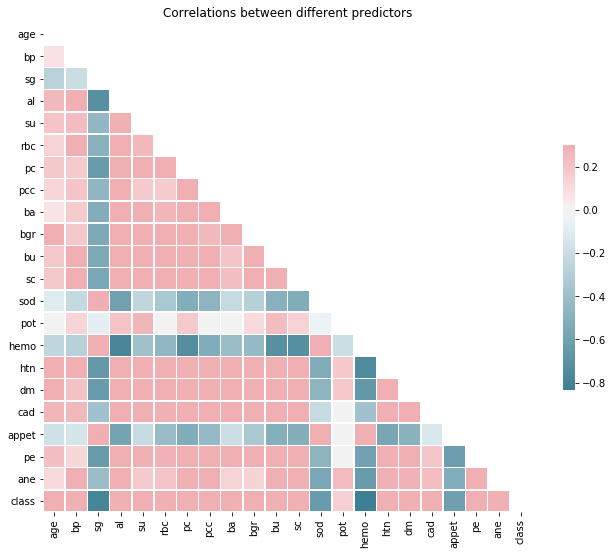

In [7]:
corr_df = df2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlations between different predictors')
plt.show()

## Split the set for training models further into a (sub-)training set and testing set.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df2.iloc[:,:-1], df2['class'], 
                                                    test_size = 0.33, random_state=44,
                                                   stratify= df2['class'] )


In [9]:
print(X_train.shape)
print(X_test.shape)

(105, 24)
(53, 24)


In [10]:
y_train.value_counts()

0.0    76
1.0    29
Name: class, dtype: int64

## Choosing parameters with GridSearchCV with 10-fold cross validations.


Detailed classification report:
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00        39
        1.0       1.00      1.00      1.00        14

avg / total       1.00      1.00      1.00        53

Confusion Matrix:
[[39  0]
 [ 0 14]]


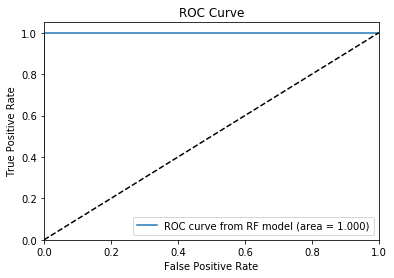

Best parameters:
{'class_weight': None, 'max_depth': 2, 'n_estimators': 8, 'random_state': 42}


In [11]:
tuned_parameters = [{'n_estimators':[7,8,9,10,11,12,13,14,15,16],'max_depth':[2,3,4,5,6,None],
                     'class_weight':[None,{0: 0.33,1:0.67},'balanced'],'random_state':[42]}]
clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=10,scoring='f1')
clf.fit(X_train, y_train)

print("Detailed classification report:")
y_true, lr_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, lr_pred))

confusion = confusion_matrix(y_test, lr_pred)
print('Confusion Matrix:')
print(confusion)

# Determine the false positive and true positive rates
fpr,tpr,roc_auc = auc_scorer(clf, X_test, y_test, 'RF')

print('Best parameters:')
print(clf.best_params_)
clf_best = clf.best_estimator_


# Examine feature importance
Since We pruned the forest (*max_depth*=2) and decrease the number of trees (*n_estimators*=8), not all features are used.

Text(0.5,1,'Feature Importance')

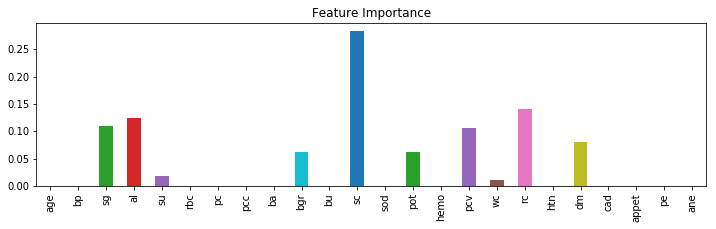

In [12]:
plt.figure(figsize=(12,3))
features = X_test.columns.values.tolist()
importance = clf_best.feature_importances_.tolist()
feature_series = pd.Series(data=importance,index=features)
feature_series.plot.bar()
plt.title('Feature Importance')

In [13]:
list_to_fill = X_test.columns[feature_series>0]
print(list_to_fill)

Index(['sg', 'al', 'su', 'bgr', 'sc', 'pot', 'pcv', 'wc', 'rc', 'dm'], dtype='object')


# Next, We examine the rest of the dataset (with missing values across the rows)
Are there correlations between occurence of missing values in a row? The plot suggests, seems no.

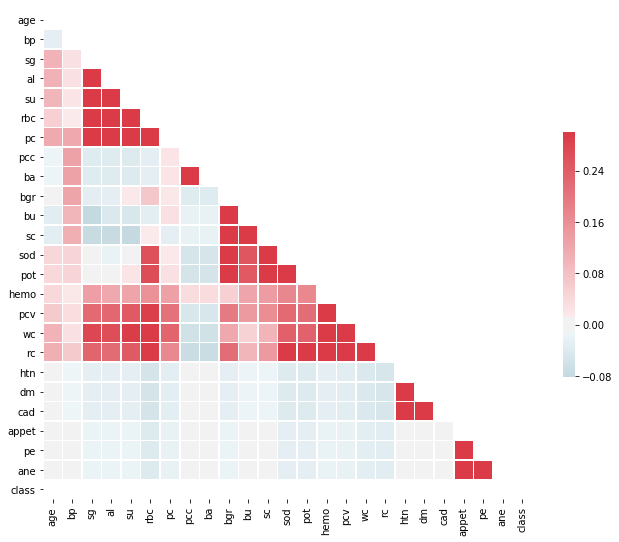

In [14]:
# Are there correlation in missing values?
corr_df = pd.isnull(df).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# Make predictions with the best model selected above
WE filled in all NaN with 0 and pass it to the trained classifier. The results are as follows:
- True positive = 180
- True negative = 35
- False positive = 0
- False negative = 27
----
- Accuracy = 88.8%
- ROC AUC = 99.2%

             precision    recall  f1-score   support

        0.0       0.56      1.00      0.72        35
        1.0       1.00      0.87      0.93       207

avg / total       0.94      0.89      0.90       242

Confusion Matrix:
[[ 35   0]
 [ 27 180]]

 Accuracy: 0.888430


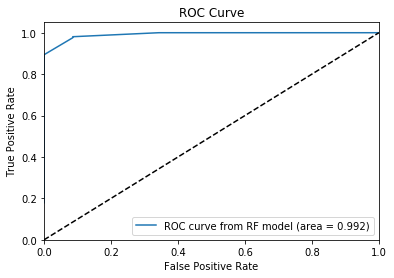

 Accuracy: 0.979167


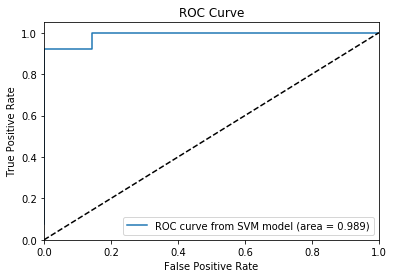

In [24]:
df2 = df.dropna(axis=0)
no_na = df2.index.tolist()
some_na = df.drop(no_na).apply(lambda x: pd.to_numeric(x,errors='coerce'))
some_na = some_na.fillna(0) # Fill up all Nan by zero.

X_test = some_na.iloc[:,:-1]
y_test = some_na['class']
y_true = y_test
lr_pred = clf_best.predict(X_test)
print(classification_report(y_true, lr_pred))

confusion = confusion_matrix(y_test, lr_pred)
print('Confusion Matrix:')
print(confusion)

print('\n Accuracy: %3f' % accuracy_score(y_true, lr_pred))
# Determine the false positive and true positive rates
fpr,tpr,roc_auc = auc_scorer(clf_best, X_test, y_test, 'RF')


df2.head()

Y=df2["class"].values
#print(list_to_fill)
X=df2[list_to_fill]
X_train, X_test,y_train,y_test=train_test_split(X,Y, test_size=0.3, random_state=24)
clf= svm.SVC(kernel='linear',random_state=24)
clf.fit(X_train,y_train)
preds=clf.predict(X_test)
clf.score(X_test,y_test)
print(' Accuracy: %3f' % clf.score(X_test,y_test))
fpr,tpr,roc_auc = auc_scorer(clf, X_test, y_test, 'SVM')

df_temp = df2[['sg','al','su','bgr','sc','pot','pcv','wc','rc','dm','class']]
df3 = df_temp
#df3.info()
##df3['class'].unique()
df3.to_csv('kidney_disease1.csv',sep=',',encoding='utf-8',index=False)



In [ ]:
df4= pd.read_csv('kidney_disease1.csv')
df4.head()